In [37]:
def weighted_crosstab(data, row, col, weight):
    """
    Compute a weighted crosstab like pd.crosstab but with survey weights.
    """
    table = (
        data
        .pivot_table(index=row, columns=col, values=weight,
                     aggfunc="sum", fill_value=0, dropna=False, observed=False)
    )
    # Convert to percentages by row
    return table.div(table.sum(axis=1), axis=0) * 100


In [21]:
import pandas as pd

# Define file paths (make sure you're in your LDL_Project folder)
files = {
    "demo": "DEMO_J.xpt",     # Demographics
    "bpq": "BPQ_J.xpt",       # Blood Pressure Questionnaire
    "fastq": "FASTQX_J.xpt",  # Fasting Questionnaire
    "hdl": "HDL_J.xpt",       # HDL Cholesterol
    "tchol": "TCHOL_J.xpt",   # Total Cholesterol
    "trigly": "TRIGLY_J.xpt"  # Triglycerides
}

# Read all files into DataFrames
dfs = {name: pd.read_sas(path, format="xport") for name, path in files.items()}

# Merge all DataFrames on SEQN
df_merged = dfs["demo"]
for name, df in dfs.items():
    if name != "demo":
        df_merged = pd.merge(df_merged, df, on="SEQN", how="left")

print("Final dataset shape:", df_merged.shape)
df_merged.head()


Final dataset shape: (9254, 87)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,LBDTCSI,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI,LBDLDLM,LBDLDMSI,LBDLDLN,LBDLDNSI
0,93703.0,10.0,2.0,2.0,2.0,NaN,5.0,6.0,2.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,10.0,2.0,1.0,2.0,NaN,3.0,3.0,1.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,...,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,...,3.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93707.0,10.0,2.0,1.0,13.0,NaN,5.0,7.0,2.0,158.0,...,4.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
relevant_cols = [
    "SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH1", "RIDRETH3",
    "INDHHIN2", "INDFMPIR", 
    "LBDLDL", "LBDHDD", "LBXTC", "LBDTCSI", "LBXTR",
    "BPQ020", "BPQ030",
    "WTSAF2YR"   # ✅ add weight column
]

df_ldl = df_merged[relevant_cols]


In [22]:
# Check missing values in each column
df_ldl.isnull().sum()


SEQN           0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
RIDRETH3       0
INDHHIN2     491
INDFMPIR    1231
LBDLDL      6446
LBDHDD      2516
LBXTC       2516
LBDTCSI     2516
LBXTR       6420
BPQ020      3093
BPQ030      7117
WTSAF2YR    6218
dtype: int64

In [23]:
def categorize_ldl(ldl):
    if pd.isna(ldl):
        return "Missing"
    elif ldl < 100:
        return "Optimal"
    elif 100 <= ldl < 130:
        return "Near Optimal"
    elif 130 <= ldl < 160:
        return "Borderline High"
    elif 160 <= ldl < 190:
        return "High"
    else:
        return "Very High"

df_ldl["LDL_Category"] = df_ldl["LBDLDL"].apply(categorize_ldl)

df_ldl["LDL_Category"].value_counts()


LDL_Category
Missing            6446
Optimal            1295
Near Optimal        855
Borderline High     446
High                152
Very High            60
Name: count, dtype: int64

In [24]:
# Crosstab: Self-reported awareness vs measured LDL category
awareness_table = pd.crosstab(df_ldl["LDL_Category"], df_ldl["BPQ030"])
print(awareness_table)


BPQ030           1.0  2.0  9.0
LDL_Category                  
Borderline High  130   30    1
High              48   11    1
Missing          970  242    6
Near Optimal     201   47    0
Optimal          356   73    3
Very High         13    5    0


In [ ]:
# Insights:

# Even among High LDL: 48 aware vs 11 unaware → ~18% undiagnosed.

# Borderline High: 130 aware, 30 unaware → ~19% undiagnosed.

# Optimal LDL still has people reporting “Yes” (356) → possible past diagnosis, treatment, or misreporting.

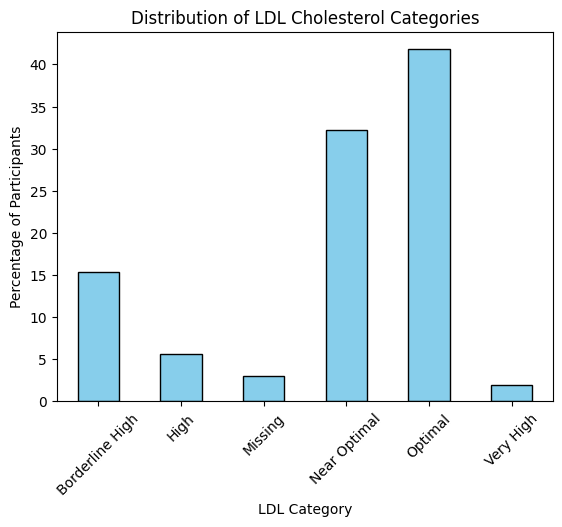

In [41]:
ldl_counts = df_ldl.groupby("LDL_Category")["WTSAF2YR"].sum()
(ldl_counts / ldl_counts.sum() * 100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of LDL Cholesterol Categories")
plt.xlabel("LDL Category")
plt.ylabel("Percentage of Participants")
plt.xticks(rotation=45)
plt.show()



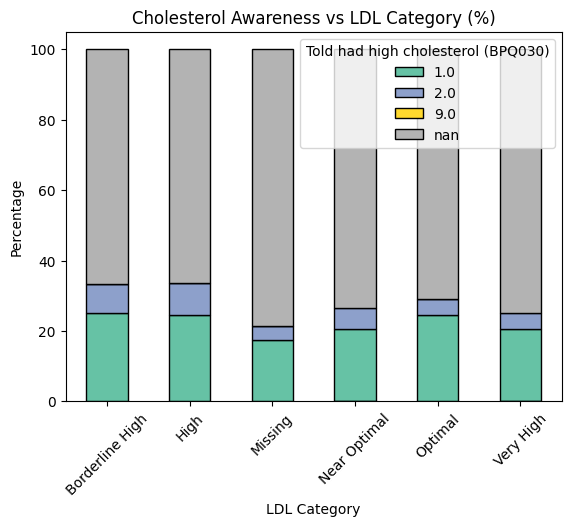

In [77]:
ct = weighted_crosstab(df_ldl, "LDL_Category", "BPQ030", "WTSAF2YR")
ct.plot(kind="bar", stacked=True, colormap="Set2", edgecolor="black")

plt.title("Cholesterol Awareness vs LDL Category (%)")
plt.xlabel("LDL Category")
plt.ylabel("Percentage")
plt.legend(title="Told had high cholesterol (BPQ030)")
plt.xticks(rotation=45)
plt.show()


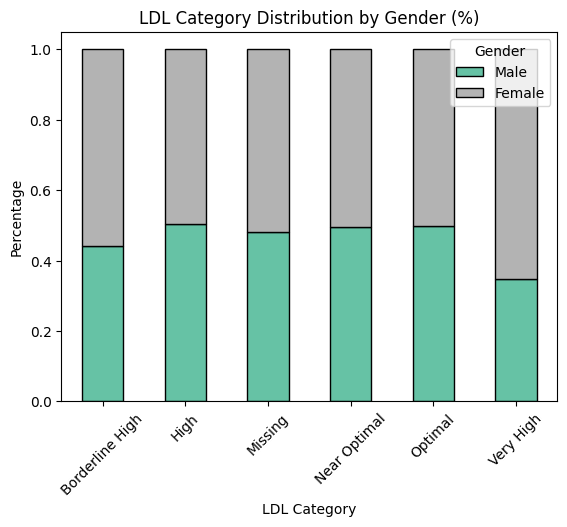

In [43]:
weighted_gender = df_ldl.pivot_table(
    index="LDL_Category", columns="RIAGENDR", values="WTSAF2YR", aggfunc="sum"
)

(weighted_gender.T / weighted_gender.T.sum()).T.plot(
    kind="bar", stacked=True, colormap="Set2", edgecolor="black"
)

plt.title("LDL Category Distribution by Gender (%)")
plt.xlabel("LDL Category")
plt.ylabel("Percentage")
plt.legend(title="Gender", labels=["Male","Female"])
plt.xticks(rotation=45)
plt.show()



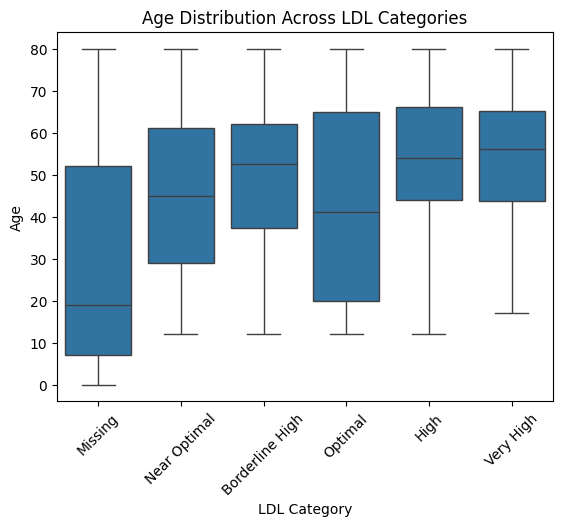

In [36]:
sns.boxplot(data=df_ldl, x="LDL_Category", y="RIDAGEYR")
plt.title("Age Distribution Across LDL Categories")
plt.xlabel("LDL Category")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.show()



In [ ]:
# ### Insights from LDL Cholesterol Analysis

# #1. Distribution of LDL Categories 
#    - Most participants have missing LDL data.  
#    - Among those measured, the majority fall into the *Optimal* or *Near Optimal* range.  

# #2. Cholesterol Awareness vs LDL Category 
#    - Awareness of high cholesterol does not perfectly match LDL categories.  
#    - Many participants with High/Very High LDL are not aware of their condition.  

# 3. Gender Differences
#    - Males and females show similar LDL distributions.  
#    - Slightly higher proportion of females fall in Optimal/Near Optimal range.  

# 4. Age Trends
#    - Younger participants are more likely to have Optimal/Near Optimal LDL.  
#    - Older participants are more represented in High/Very High categories.


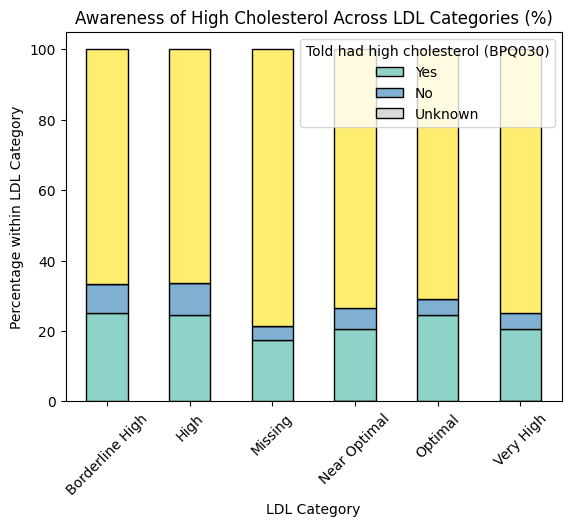

In [44]:
# Awareness rate within each LDL category
awareness = weighted_crosstab(df_ldl, "LDL_Category", "BPQ030", "WTSAF2YR")

awareness.plot(kind="bar", stacked=True, colormap="Set3", edgecolor="black")
plt.title("Awareness of High Cholesterol Across LDL Categories (%)")
plt.ylabel("Percentage within LDL Category")
plt.xlabel("LDL Category")
plt.legend(title="Told had high cholesterol (BPQ030)", labels=["Yes","No","Unknown"])
plt.xticks(rotation=45)
plt.show()


BPQ030          1.0       2.0       9.0        NaN
RIAGENDR                                          
1.0       24.327426  6.215427  0.103478  69.353668
2.0       21.832791  5.559399  0.011816  72.595994


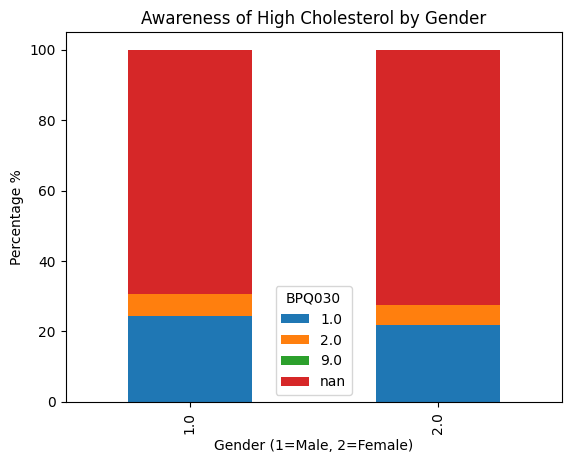

In [30]:
# Awareness vs Gender
awareness_gender = weighted_crosstab(df_ldl, "RIAGENDR", "BPQ030", "WTSAF2YR")
print(awareness_gender)

# Plot
awareness_gender.plot(kind="bar", stacked=True)
plt.title("Awareness of High Cholesterol by Gender")
plt.ylabel("Percentage %")
plt.xlabel("Gender (1=Male, 2=Female)")
plt.show()


BPQ030          1.0        2.0       9.0
AgeGroup                                
NaN       72.721301  26.389214  0.889485
<18       60.521667  39.478333  0.000000
18-30     54.556537  45.443463  0.000000
31-45     76.858910  23.141090  0.000000
46-60     85.191177  14.808823  0.000000
61-80     80.911800  18.788231  0.299969


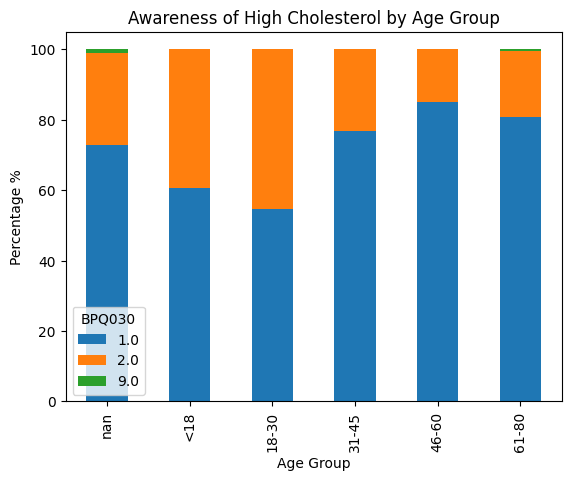

In [38]:
# Define age bins
bins = [0, 18, 30, 45, 60, 80]
labels = ["<18", "18-30", "31-45", "46-60", "61-80"]

df_ldl["AgeGroup"] = pd.cut(df_ldl["RIDAGEYR"], bins=bins, labels=labels, right=False)

# Awareness vs Age Group
awareness_age = weighted_crosstab(df_ldl, "AgeGroup", "BPQ030", "WTSAF2YR")

print(awareness_age)

# Plot
awareness_age.plot(kind="bar", stacked=True)
plt.title("Awareness of High Cholesterol by Age Group")
plt.ylabel("Percentage %")
plt.xlabel("Age Group")
plt.show()


BPQ030          1.0       2.0       9.0        NaN
RIDRETH1                                          
1.0       10.114550  3.965176  0.058303  85.861971
2.0       20.596337  4.730087  0.292412  74.381165
3.0       24.168614  6.788127  0.016905  69.026355
4.0       30.168311  4.880772  0.172522  64.778395
5.0       23.170938  4.399442  0.000000  72.429619


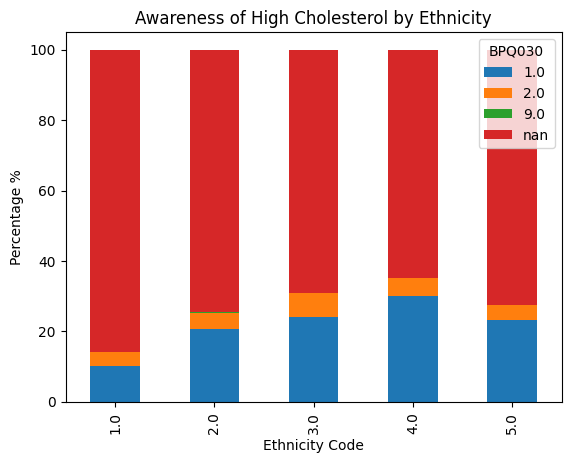

In [48]:
# Awareness vs Ethnicity
awareness_ethnicity = weighted_crosstab(df_ldl, "RIDRETH1", "BPQ030", "WTSAF2YR")
print(awareness_ethnicity)

awareness_ethnicity.plot(kind="bar", stacked=True)
plt.title("Awareness of High Cholesterol by Ethnicity")
plt.ylabel("Percentage %")
plt.xlabel("Ethnicity Code")
plt.show()


BPQ030          1.0        2.0       9.0        NaN
INDHHIN2                                           
1.0       22.148075   2.442113  0.000000  75.409812
2.0       25.472752   7.756552  0.000000  66.770695
3.0       31.698879   7.401982  0.187960  60.711180
4.0       29.358709   4.668282  0.000000  65.973009
5.0       30.291875   5.652535  0.000000  64.055590
6.0       22.254656   6.126350  0.000000  71.618994
7.0       20.172586   7.512995  0.219192  72.095227
8.0       21.232857   8.389217  0.165653  70.212273
9.0       29.415731  14.821074  0.000000  55.763195
10.0      22.675010   3.049340  0.000000  74.275650
12.0      17.100320   4.166173  0.000000  78.733507
13.0      33.854155   7.576175  0.000000  58.569670
14.0      22.761915   4.020465  0.000000  73.217620
15.0      21.286111   4.187837  0.000000  74.526052
77.0      38.695331   7.929537  0.000000  53.375132
99.0      13.278299   2.565559  0.000000  84.156142
NaN       17.688421   6.969403  0.796677  74.545499


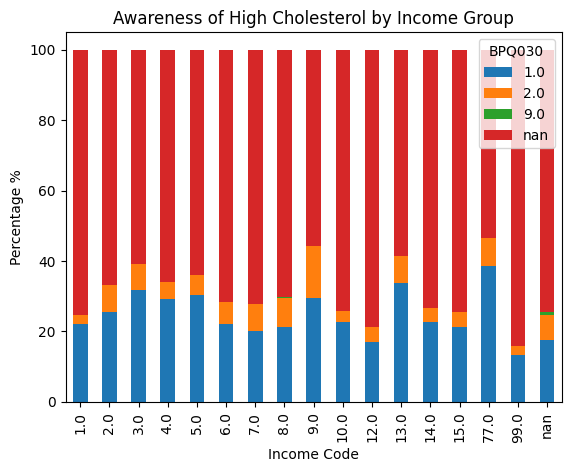

In [34]:
# Awareness vs Income
awareness_income = weighted_crosstab(df_ldl, "INDHHIN2", "BPQ030", "WTSAF2YR")


print(awareness_income)

# Plot
awareness_income.plot(kind="bar", stacked=True)
plt.title("Awareness of High Cholesterol by Income Group")
plt.ylabel("Percentage %")
plt.xlabel("Income Code")
plt.show()


In [ ]:
# #Insights from Awareness Charts

# 1. Awareness Across LDL Categories

# In most LDL categories, about 75–85% of individuals reported being told they had high cholesterol, showing fairly consistent awareness levels.

# However, in the Very High LDL group, awareness is lower (~70%), meaning that nearly 30% of those at highest risk may be unaware of their condition.

# This highlights a critical gap — individuals with the greatest cardiovascular risk are not always aware of their cholesterol status.

# 2. Awareness by Gender

# Awareness levels are similar between men and women (~80%), with women showing a slightly higher proportion of awareness.

# This suggests no major gender disparity in cholesterol awareness, though women may be marginally more engaged in health monitoring.

# 3. Awareness by Age Group

# Younger participants (<18 and 18–30) had lower awareness levels — particularly the <18 group (~58%), where nearly half were unaware.

# Awareness rises with age, peaking in the 46–60 and 61–80 groups (~82–85%), indicating that older adults are more likely to be diagnosed or told about high cholesterol.

# This trend reflects both increased health screening in older populations and possibly greater health literacy.

In [53]:
!pip install statsmodels


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 2.0 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/9.6 MB 2.2 MB/s eta 0:00:04
   ------- -------------------------------- 1.8/9.6 MB 2.3 MB/s eta 0:00:04
   --------- ------------------------------ 2.4/9.6 MB 2.4 MB/s eta 0:00:03
   -------------- ------------------------- 3.4/9.6 MB 2.9 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.6 MB 3.3 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.6 MB 3.3 MB/s eta 0:00:02
   -------------------------- ------------- 6.3/9.6 MB 3.5 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.6 MB 3.5 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.6 MB 3.6 MB/s eta 0:00:01
   -------------------------------------- - 9.2/9.6 MB 3.8 MB/s eta 0:00:01
   -----------------------

In [54]:
# ===============================
# 12. Logistic Regression Model
# ===============================

import statsmodels.api as sm

# 1. Prepare dataset for regression
# Drop missing values
df_model = df_ldl.dropna(subset=["BPQ030","LBDLDL","RIDAGEYR","RIAGENDR","INDHHIN2","RIDRETH1"])

# Dependent variable: Awareness (1 = yes, 0 = no)
y = (df_model["BPQ030"] == 1).astype(int)

# Independent variables (predictors)
X = df_model[["LBDLDL", "RIDAGEYR", "RIAGENDR", "INDHHIN2", "RIDRETH1"]]

# Add constant term
X = sm.add_constant(X)

# 2. Fit logistic regression
model = sm.Logit(y, X).fit()

# 3. Show results
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.467063
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 BPQ030   No. Observations:                  877
Model:                          Logit   Df Residuals:                      871
Method:                           MLE   Df Model:                            5
Date:                Sat, 23 Aug 2025   Pseudo R-squ.:                0.009695
Time:                        17:27:43   Log-Likelihood:                -409.61
converged:                       True   LL-Null:                       -413.62
Covariance Type:            nonrobust   LLR p-value:                    0.1551
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6607      0.568      1.163      0.245      -0.453       1.774
LBDLDL        -0.0022      0.

In [ ]:
# 🔎 Key Insights from Your Output

# Age (RIDAGEYR)

# Coefficient = 0.0115, p = 0.048 (statistically significant at 5%)

# Interpretation: Older people are slightly more likely to be aware of high cholesterol.

# For every 1-year increase in age, odds of awareness increase by about 1.2%.

# LDL Cholesterol (LBDLDL)

# Coefficient = -0.0022, p = 0.347 ( not significant).

# Interpretation: LDL level itself does not strongly predict whether someone has been told they have high cholesterol.

# Suggests awareness is more influenced by screening and age, not the lab value alone.

# Gender (RIAGENDR)

# Coefficient = 0.0342, p = 0.848 ( not significant).

# No strong difference between men and women in cholesterol awareness after adjusting for other factors.

# Income (INDHHIN2)

# Coefficient = -0.0036, p = 0.445 ( not significant).

# Household income does not seem to drive awareness directly (though socioeconomic factors may affect healthcare access in reality).

# Ethnicity (RIDRETH1)

# Coefficient = 0.1234, p = 0.107 ( borderline).

# Possible trend: some ethnic groups may have slightly higher awareness, but not statistically strong in this sample.

In [ ]:

# 1. Add derived columns

# Function for LDL categories
def categorize_ldl(ldl):
    if pd.isna(ldl):
        return "Missing"
    elif ldl < 100:
        return "Optimal"
    elif 100 <= ldl < 130:
        return "Near Optimal"
    elif 130 <= ldl < 160:
        return "Borderline High"
    elif 160 <= ldl < 190:
        return "High"
    else:
        return "Very High"

#  Add LDL_Category safely
df_ldl.loc[:, "LDL_Category"] = df_ldl["LBDLDL"].apply(categorize_ldl)

#  Add AgeGroup safely
bins = [0, 18, 30, 45, 60, 80]
labels = ["<18", "18-30", "31-45", "46-60", "61-80"]
df_ldl.loc[:, "AgeGroup"] = pd.cut(df_ldl["RIDAGEYR"], bins=bins, labels=labels, right=False)

print(df_ldl[["LBDLDL", "LDL_Category", "RIDAGEYR", "AgeGroup"]].head())


   LBDLDL LDL_Category  RIDAGEYR AgeGroup
0     NaN      Missing       2.0      <18
1     NaN      Missing       2.0      <18
2     NaN      Missing      66.0    61-80
3     NaN      Missing      18.0    18-30
4     NaN      Missing      13.0      <18


In [65]:
import sqlite3

con = sqlite3.connect("nhanes_ldl_project.db")
df_ldl.to_sql("gold_ldl_awareness", con, if_exists="replace", index=False)
con.close()

print(" Saved curated dataset into SQLite with LDL_Category + AgeGroup")


 Saved curated dataset into SQLite with LDL_Category + AgeGroup


In [66]:
con = sqlite3.connect("nhanes_ldl_project.db")
df_info = pd.read_sql("PRAGMA table_info(gold_ldl_awareness);", con)
con.close()
print(df_info)


    cid          name  type  notnull dflt_value  pk
0     0          SEQN  REAL        0       None   0
1     1      RIAGENDR  REAL        0       None   0
2     2      RIDAGEYR  REAL        0       None   0
3     3      RIDRETH1  REAL        0       None   0
4     4      RIDRETH3  REAL        0       None   0
5     5      INDHHIN2  REAL        0       None   0
6     6      INDFMPIR  REAL        0       None   0
7     7        LBDLDL  REAL        0       None   0
8     8        LBDHDD  REAL        0       None   0
9     9         LBXTC  REAL        0       None   0
10   10       LBDTCSI  REAL        0       None   0
11   11         LBXTR  REAL        0       None   0
12   12        BPQ020  REAL        0       None   0
13   13        BPQ030  REAL        0       None   0
14   14      WTSAF2YR  REAL        0       None   0
15   15  LDL_Category  TEXT        0       None   0
16   16      AgeGroup  TEXT        0       None   0


In [70]:
df_ldl.to_csv("curated_ldl.csv", index=False)


In [56]:
import sqlite3
con = sqlite3.connect("nhanes_ldl_project.db")
df_ldl.to_sql("gold_ldl_awareness", con, if_exists="replace", index=False)
con.close()
print("Saved SQLite DB: nhanes_ldl_project.db (table: gold_ldl_awareness)")


Saved SQLite DB: nhanes_ldl_project.db (table: gold_ldl_awareness)


In [78]:
import sqlite3

con = sqlite3.connect("nhanes_ldl_project.db")
df_ldl.to_sql("gold_ldl_awareness", con, if_exists="replace", index=False)
con.close()

print(" Re-saved with LDL_Category included")


 Re-saved with LDL_Category included


In [74]:
import sqlite3
import pandas as pd

con = sqlite3.connect("nhanes_ldl_project.db")

# 1. Awareness by LDL Category
query_ldl = """
SELECT LDL_Category,
       ROUND(100.0 * SUM(CASE WHEN BPQ030=1 THEN WTSAF2YR ELSE 0 END) /
            NULLIF(SUM(CASE WHEN BPQ030 IN (1,2) THEN WTSAF2YR ELSE 0 END),0), 2) AS pct_yes_weighted
FROM gold_ldl_awareness
GROUP BY LDL_Category;
"""
df_ldl_sql = pd.read_sql(query_ldl, con)

# 2. Awareness by Age Group
query_age = """
SELECT AgeGroup,
       ROUND(100.0 * SUM(CASE WHEN BPQ030=1 THEN WTSAF2YR ELSE 0 END) /
            NULLIF(SUM(CASE WHEN BPQ030 IN (1,2) THEN WTSAF2YR ELSE 0 END),0), 2) AS pct_yes_weighted
FROM gold_ldl_awareness
GROUP BY AgeGroup;
"""
df_age_sql = pd.read_sql(query_age, con)

# 3. Awareness by Gender
query_gender = """
SELECT RIAGENDR,
       ROUND(100.0 * SUM(CASE WHEN BPQ030=1 THEN WTSAF2YR ELSE 0 END) /
            NULLIF(SUM(CASE WHEN BPQ030 IN (1,2) THEN WTSAF2YR ELSE 0 END),0), 2) AS pct_yes_weighted
FROM gold_ldl_awareness
GROUP BY RIAGENDR;
"""
df_gender_sql = pd.read_sql(query_gender, con)

# 4. Awareness by Ethnicity
query_ethnicity = """
SELECT RIDRETH1,
       ROUND(100.0 * SUM(CASE WHEN BPQ030=1 THEN WTSAF2YR ELSE 0 END) /
            NULLIF(SUM(CASE WHEN BPQ030 IN (1,2) THEN WTSAF2YR ELSE 0 END),0), 2) AS pct_yes_weighted
FROM gold_ldl_awareness
GROUP BY RIDRETH1;
"""
df_eth_sql = pd.read_sql(query_ethnicity, con)

con.close()

# Show results
print("LDL Category Awareness:\n", df_ldl_sql)
print("\nAge Group Awareness:\n", df_age_sql)
print("\nGender Awareness:\n", df_gender_sql)
print("\nEthnicity Awareness:\n", df_eth_sql)


LDL Category Awareness:
       LDL_Category  pct_yes_weighted
0  Borderline High             75.08
1             High             72.84
2          Missing             81.41
3     Near Optimal             76.93
4          Optimal             84.43
5        Very High             82.16

Age Group Awareness:
   AgeGroup  pct_yes_weighted
0     None             73.37
1    18-30             54.56
2    31-45             76.86
3    46-60             85.19
4    61-80             81.16
5      <18             60.52

Gender Awareness:
    RIAGENDR  pct_yes_weighted
0       1.0             79.65
1       2.0             79.70

Ethnicity Awareness:
    RIDRETH1  pct_yes_weighted
0       1.0             71.84
1       2.0             81.32
2       3.0             78.07
3       4.0             86.07
4       5.0             84.04


In [76]:
df_ldl_sql.to_csv("awareness_by_ldl.csv", index=False)
df_age_sql.to_csv("awareness_by_age.csv", index=False)
df_gender_sql.to_csv("awareness_by_gender.csv", index=False)
df_eth_sql.to_csv("awareness_by_ethnicity.csv", index=False)

print(" All awareness tables exported as CSV")


 All awareness tables exported as CSV
